## 1. Install Packages

In [1]:
# restart runtime after running and skip this cell
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.9 MB/s eta 0:00:00


##2. Import Packages

In [1]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm

##3. Create Simple RL Model

In [2]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [3]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

In [44]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials))
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

##4. Simulate Model

In [45]:
seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
n_trials = 1000
temperature = 0.8
alpha = 0.1

In [46]:
rl_model = SimpleRL(n_trials=n_trials, distributions=dists)
rewards, choices = rl_model.simulate(alpha,temperature)
qs = rl_model.q_trace

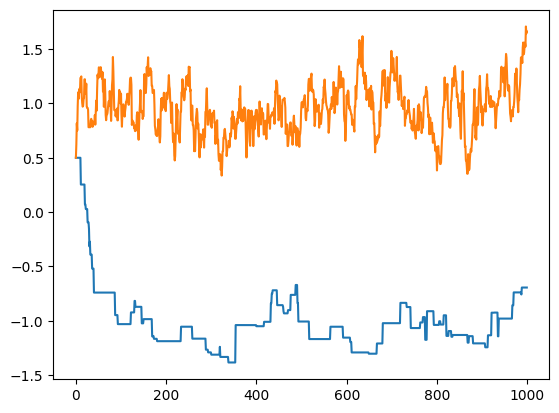

In [47]:
# plotting q values
plt.plot(qs)

##5. Create Loglikelihood Function in PyTensor

###5a. Simulate RL Q-Values

In [48]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty matrix to store q-values across trials
a = pt.scalar("a") # learning rate

# function for a single RL step
def rl_step(c, r, q_tm1):
  m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
  rm = r * m
  qm = q_tm1 * m
  return q_tm1 + a * (rm - qm)

# scan function build
Qs, updates = pytensor.scan(rl_step, sequences=[C,R], outputs_info=Q)

# Q Prediction function compilation
q_predict = pytensor.function(inputs=[C, R, Q, a], outputs=Qs)

# test values
C_test = np.random.choice(2, size = (100,)).astype(np.int32)
R_test = np.ones((100,), dtype=np.float32)
Q_test = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
a_test = 0.1

# RL Model function test
q_predict(C_test,R_test,Q_test,a_test)

array([[0.1       , 0.        ],
       [0.1       , 0.1       ],
       [0.1       , 0.19      ],
       [0.19      , 0.19      ],
       [0.19      , 0.271     ],
       [0.19      , 0.3439    ],
       [0.271     , 0.3439    ],
       [0.271     , 0.40951   ],
       [0.271     , 0.468559  ],
       [0.3439    , 0.468559  ],
       [0.40951   , 0.468559  ],
       [0.40951   , 0.5217031 ],
       [0.468559  , 0.5217031 ],
       [0.5217031 , 0.5217031 ],
       [0.56953279, 0.5217031 ],
       [0.61257951, 0.5217031 ],
       [0.65132156, 0.5217031 ],
       [0.6861894 , 0.5217031 ],
       [0.6861894 , 0.56953279],
       [0.6861894 , 0.61257951],
       [0.71757046, 0.61257951],
       [0.74581342, 0.61257951],
       [0.74581342, 0.65132156],
       [0.77123208, 0.65132156],
       [0.77123208, 0.6861894 ],
       [0.79410887, 0.6861894 ],
       [0.79410887, 0.71757046],
       [0.81469798, 0.71757046],
       [0.83322818, 0.71757046],
       [0.84990536, 0.71757046],
       [0.

###5b. Calculate Loglikelihood of Simulation given parameters

In [27]:
# parameters & variables
C = pt.imatrix("C") # choice matrix (one-hot of choice vector)
R = pt.dmatrix("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        return q_tm1 + a * (r - q_tm1) * c

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * c).sum()
        ll = pt.log(p_select)
        return ll

    aV = pt.ones_like((Q.shape[0])) * a
    bV = pt.ones_like((Q.shape[0])) * b

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [aV], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[bV], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


output = my_ll_func(C, R, Q, a, b, ll)

loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = 1 - 2*np.ones((n_trials,n_choices), dtype=np.int32)
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test_onehot,R_test,Q_test,ll_test,a_test,b_test)

array([-0.91301525, -0.69314718, -0.88926045, -0.69314718, -0.86821218,
       -1.04758798, -1.22559113, -1.39803497, -1.56213876, -1.71626127,
       -1.85960573, -0.22717087, -0.29370937, -1.48617505, -0.32217652,
       -0.3929897 , -0.4671424 , -0.5428892 , -0.61866198, -0.85116488,
       -0.62584106, -0.83439726, -0.89988302, -0.58099241, -0.63825575,
       -0.80621852, -0.85789477, -0.90615224, -0.9509808 , -0.53352311,
       -0.92284659, -0.54812883, -0.89796385, -0.56152889, -0.87592712,
       -0.90459086, -0.55285365, -0.881799  , -0.90506835, -0.5490254 ,
       -0.57775367, -0.84366323, -0.5886176 , -0.82772923, -0.84399644,
       -0.85880975, -0.87228119, -0.88451803, -0.55524883, -0.86400678,
       -0.56805019, -0.84580482, -0.85454402, -0.86245798, -0.86961989,
       -0.56177248, -0.85078817, -0.57401918, -0.58965729, -0.81416139,
       -0.81919064, -0.59541677, -0.80595329, -0.60471442, -0.79415933,
       -0.61317229, -0.62390113, -0.63367212, -0.64255933, -0.65

##6. Calculate Likelihoods

##7. PyMC Likelihood Modelling

Wrapping model into PyMC using pm potential

Code was taken from PyMC documentation and modified

In [ ]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dvector]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, c, r):
        # add inputs as class attributes
        self.likelihood = loglike
        self.C = c
        self.R = r

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      outputs[0][0] = self.likelihood(theta[0], theta[1])



In [49]:
# Creating Ground Truth Data
n_trials = 250
mean_rewards = [-0.5,0.5]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":0.2}) for mn in mean_rewards]
rl_model = SimpleRL(n_trials=n_trials,distributions=dists)
n_choices = len(dists)

a_true = 0.1
b_true = 0.5
R_true, C_true = rl_model.simulate(a_true,b_true)
C_true_onehot = np.array(np.eye(n_choices)[C_true],dtype=np.int32)
R_true_onehot = np.repeat(np.expand_dims(R_true,axis=1),n_choices,axis=1)
Qs_true = np.ones((n_choices,)) * 0.5
ll_true = 0

/usr/local/lib/python3.10/dist-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.648426
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:04.170660
Transforming variables...
Transformation time =  0:00:00.021598


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'c', 'm'} expected from {'b', 'a'}
  warnings.warn(


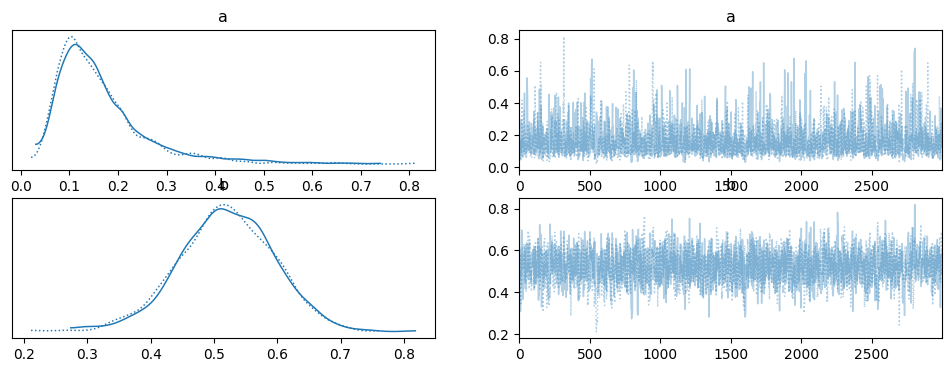

In [51]:
# use PyMC to sampler from log-likelihood
with pm.Model():
    # Data
    C = pm.ConstantData('myC', C_true_onehot)
    R = pm.ConstantData('myR', R_true_onehot)
    Q = pm.ConstantData("myQ", Qs_true)
    ll_true = pm.ConstantData('ll_true', ll_true)

    # Priors
    a = pm.Beta(name="a",alpha=2,beta=2)
    b = pm.Beta(name="b",alpha=2,beta=2)
    # a = pm.LogNormal(name="a", sigma=1.0)
    # b = pm.LogNormal(name="b", sigma=2.0)

    # convert m and c to a tensor vector

    # rl_likelihoods = pm.RLModel("name", *params, observed = (C, R))

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_ll_func(C, R, Q, a, b, ll_true))
    #pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

# plot the traces
az.plot_trace(idata_mh, lines=[("m", {}, a_true), ("c", {}, b_true)]);

<Axes: xlabel='a', ylabel='b'>

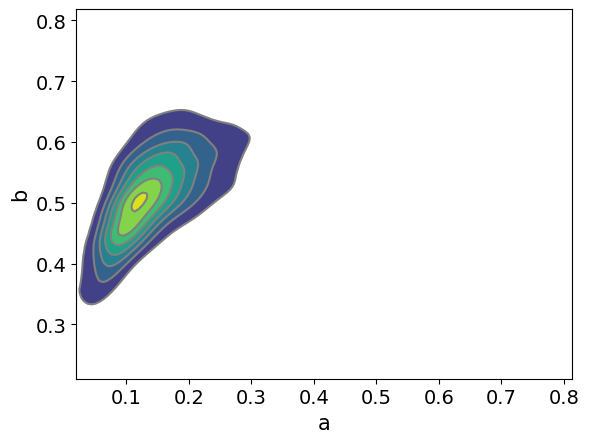

In [52]:
az.plot_pair(idata_mh, kind="kde")

##8. Model Calibration

In [12]:
def fit_pymc(R,C,priors):
  # create our Op
  logl = LogLike(loglike_func, R, C)
  # use PyMC to sampler from log-likelihood
  with pm.Model():
      # uniform priors on m and c
      prior_dists, prior_args = priors
      a = prior_dists[0](*prior_args[0])
      b = prior_dists[1](*prior_args[1])
      # convert m and c to a tensor vector
      theta = pt.as_tensor_variable([a, b])
      # use a Potential to "call" the Op and include it in the logp computation
      pm.Potential("likelihood", logl(theta))
      # Use custom number of draws to replace the HMC based defaults
      idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")
  return idata_mh

In [ ]:
# Calibration Parameters
nrep = 10
trials = 500
a_range = (0.01,0.99)
b_range = (0.01,0.99)
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
prior_dist = (pm.Uniform, pm.Uniform)
prior_args = (["a", 1e-4, 1e-0],
              ["b", 1e-4, 1e+0])  # alpha=1, beta=1; alpha=10 beta=10
priors = (prior_dist, prior_args)
# Calibrator Functions
def sample(n_trials,dists,a,b):
  return SimpleRL(n_trials=n_trials,distributions=dists).simulate(alpha=a,temperature=b)

In [ ]:
# quantiles = np.zeros((nrep,2))
# for rep_i in tqdm(range(nrep)):
#   a_true = np.random.uniform(*a_range)
#   b_true = np.random.uniform(*b_range)
#   y_R, y_C = sample(trials,dists,a_true,b_true)
#   data = fit_pymc(y_R, y_C, priors)
#   quantiles[rep_i,0] = np.mean(data.posterior.a > a_true)
#   quantiles[rep_i,1] = np.mean(data.posterior.b > b_true)
#   az.plot_trace(data, lines=[("m", {}, a_true), ("c", {}, b_true)])

In [ ]:
# plt.hist(quantiles[:,0])
# plt.show()
# plt.hist(quantiles[:,1])
# plt.show()
# quantiles

##9. Hierarchical Bayes for Reinforcment Learning

Create Multi-participant RL data

In [72]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)

  def get_params(self):
    return self.alphas, self.temperatures


In [66]:
n_trials = 100
n_participants = 5
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)
data.shape

(500, 4)

###9a. Get Likelihoods from multi-participant RL data

In [107]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dvector("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dvector("B") # scalars of RL decision temperatures OVER PARTICIPANTS
mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll_func(CM, RM, QM, mll, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, A, Q_tm1):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: vector (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # llV: vector
    def ll_def(C, Qs, mll, B):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.matmul(denom.reshape((denom.shape[0],1)),pt.ones((1,Qs.shape[1])))  # Reshaping denominator to have same dimensionality as numerator (participants,choices)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        # Ps = pt.special.softmax(pt.true_div(Qs,B))
        P_select = pt.mul(Ps,C).sum(axis=1)
        mll = pt.log(P_select)
        return mll

    n_choices = QM.shape[1]
    #AM = pt.extra_ops.repeat(pt.shape_padright(A),n_choices,axis=1)
    #BM = pt.extra_ops.repeat(pt.shape_padright(B),n_choices,axis=1)
    #AM = pt.eye(n_choices) * A
    #BM = pt.eye(n_choices) * B
    A = A.reshape((A.shape[0],1))
    B = B.reshape((B.shape[0],1))
    AM =  pt.matmul(A,pt.ones((1,n_choices)))
    BM =  pt.matmul(B,pt.ones((1,n_choices)))
    assert A.shape != AM.shape
    assert B.shape != BM.shape
    #np.repeat(np.expand_dims(RM_true,axis=2),n_choices,axis=2)
    # BM = pt.tile(B,reps=(n_choices),ndim=2)
    #AM = A
    #BM = B

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [AM], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: vector --> matrix
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[BM], outputs_info=mll)

    return loglikes

output = my_mll_func(CM, RM, QM, mll, A, B)

mloglike_func = pytensor.function(inputs=[CM,RM,QM,mll,A,B],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
n_participants = 5
CM_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,n_participants)), dtype=np.int32)
CM_test_onehot = np.array(np.eye(n_participants,n_choices)[CM_test],dtype=np.int32)  # Remember to use this one
RM_test = 1 - 2*np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,n_participants)))
RM_test_repeat = np.repeat(np.expand_dims(RM_test,axis=2),n_choices,axis=2)
QM_test = np.ones(shape=(n_participants,n_choices), dtype=pytensor.config.floatX)
mll_test = np.zeros((n_participants,))
A_test = np.random.randint(low=3,high=5,size=(n_participants,)) / 10
B_test = np.random.randint(low=6,high=9,size=(n_participants,)) / 10

print(f"CM: {CM_test_onehot.shape}\nRM: {RM_test_repeat.shape}\nQM: {QM_test.shape}\nA: {A_test.shape}\nB: {B_test.shape}\nmll: {mll_test.shape}")

# # RL Loglikelihood function test
mloglike_func(CM_test_onehot,RM_test_repeat,QM_test,mll_test,A_test,B_test)

CM: (100, 5, 2)
RM: (100, 5, 2)
QM: (5, 2)
A: (5,)
B: (5,)
mll: (5,)


array([[-1.91022415, -2.27512534, -0.35373161, -0.34844458, -0.27109773],
       [-1.10318605, -0.10845867, -2.12692801, -0.57048585, -0.27109773],
       [-0.56291533, -0.53338216, -0.53634108, -1.19102551, -0.53338216],
       [-0.55435524, -0.43926253, -1.52532554, -0.57048585, -1.07005534],
       [-0.48167487, -1.07005534, -0.53634108, -1.19102551, -1.07005534],
       [-0.55435524, -0.74702467, -1.52532554, -0.57048585, -0.60039279],
       [-0.48167487, -1.07005534, -0.92814379, -0.57048585, -0.53338216],
       [-0.44175657, -0.60039279, -0.80078092, -0.57048585, -1.07005534],
       [-0.55435524, -1.07005534, -1.17110067, -0.49471072, -1.07005534],
       [-0.55435524, -0.74702467, -0.53634108, -0.57048585, -0.74702467],
       [-1.10318605, -0.98250158, -0.45601538, -0.57048585, -0.56442342],
       [-0.7549461 , -0.68441068, -1.17110067, -0.57048585, -0.45785714],
       [-1.10318605, -0.53338216, -1.17110067, -1.19102551, -1.58576531],
       [-1.10318605, -1.39108897, -1.1

###9b. Hierarchical Loglikelihood Function

In [95]:
n_trials = 100
n_participants = 5
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

# set up our data
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

ids = df['Participant_ID']
mll_true = np.zeros((n_participants,))
CM_true = np.zeros((n_trials,n_participants), dtype=np.int32)
RM_true = np.zeros((n_trials,n_participants))
QM_true = np.ones((n_participants,n_choices)) * 0.5
for id in range(n_participants):
    CM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Choices']
    RM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Rewards']

CM_true_onehot = np.array(np.eye(n_participants,n_choices)[CM_true],dtype=np.int32)  # Remember to use this one
RM_true_repeat = np.repeat(np.expand_dims(RM_true,axis=2),n_choices,axis=2)
A_true, B_true = multi_rl_model.get_params()
A_true = np.array(A_true)
B_true = np.array(B_true)
#A_true = A_test
#B_true = B_test

In [90]:
mloglike_func(CM_true_onehot,RM_true_repeat,QM_true,mll_true,A_test,B_test)

array([[-0.57302952, -0.87716614, -0.65678459, -0.60747341, -1.02415057],
       [-0.79230021, -0.73442897, -0.68581767, -0.7020798 , -0.69151608],
       [-0.96437157, -0.79424984, -0.87757809, -0.75631166, -0.64092976],
       [-0.70031617, -0.72772715, -0.68148248, -0.72588344, -0.60201454],
       [-0.6878449 , -0.86481275, -0.95742894, -0.697203  , -0.61975501],
       [-0.98533453, -0.73705117, -0.71287142, -0.83649966, -0.69601325],
       [-0.59507182, -0.91850069, -0.65175782, -0.71496539, -0.93678372],
       [-0.5489055 , -0.71219815, -0.67057505, -0.67252104, -0.60344502],
       [-0.87491811, -0.92442189, -0.61854886, -0.71800949, -0.62573432],
       [-0.56816759, -0.7247921 , -0.66679184, -0.78480458, -0.70315259],
       [-0.61628935, -0.83119881, -0.90248103, -0.71803728, -0.62194453],
       [-0.54920818, -0.74078661, -0.73068128, -0.66796963, -0.6520175 ],
       [-0.62493373, -0.71605937, -0.71211539, -0.73620086, -0.60877826],
       [-0.68666044, -0.65691434, -0.9

In [108]:
# UPDATE MODEL TO EXTEND A and B into choice dimension internally - take as vectors and make matrix on the inside

with pm.Model(coords=coords) as hierarchical_model:
    # Data
    CM = pm.ConstantData('myCM', CM_true_onehot)
    RM = pm.ConstantData('myRM', RM_true_repeat)
    QM = pm.ConstantData("myQM", QM_true)
    mll = pm.ConstantData('mll', mll_true)
    # IDs = pm.ConstantData("myIDs", ids)

    # mlogl = MultiLogLike(my_ll_func,R,C,IDs,n_ids,n_trials)

    # Hyperpriors for group nodes
    #alpha_a = pm.HalfNormal(name="alpha_a", sigma=2.0)
    #beta_a = pm.HalfNormal(name="beta_a", sigma=5.0)
    #alpha_b = pm.HalfNormal(name="alpha_b", sigma=2.0)
    #beta_b = pm.HalfNormal(name="beta_b", sigma=2.0)
    alpha_a = pm.Uniform(name="alpha_a", lower=0.1,upper=0.3)
    beta_a = pm.Uniform(name="beta_a", lower=0.5,upper=0.9)
    alpha_b = pm.Uniform(name="alpha_b", lower=0.1,upper=0.3)
    beta_b = pm.Uniform(name="beta_b", lower=0.5,upper=0.9)

    # Intercept for each participant, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_participants).
    A = pm.Uniform(name="A",lower=alpha_a,upper=beta_a,dims="Participant")
    B = pm.Uniform(name="B",lower=alpha_b,upper=beta_b,dims="Participant")
    #A = pm.Beta(name="A",alpha=alpha_a,beta=beta_a,dims="Participant")
    #B = pm.Beta(name="B",alpha=alpha_b,beta=beta_b,dims="Participant")

    # convert m and c to a tensor vector
    # theta = pt.as_tensor_variable([A, B])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_mll_func(CM, RM, QM, mll, A, B))
    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

ValueError: ignored

In [175]:
mll = np.zeros((n_participants,))
mloglike_func(CM_true_onehot,RM_true_onehot,QM_true,mll,np.array([0.3,0.3,0.3,0.3,0.3]),np.array([0.5,0.5,0.5,0.5,0.5]))

array(-384.94836039)

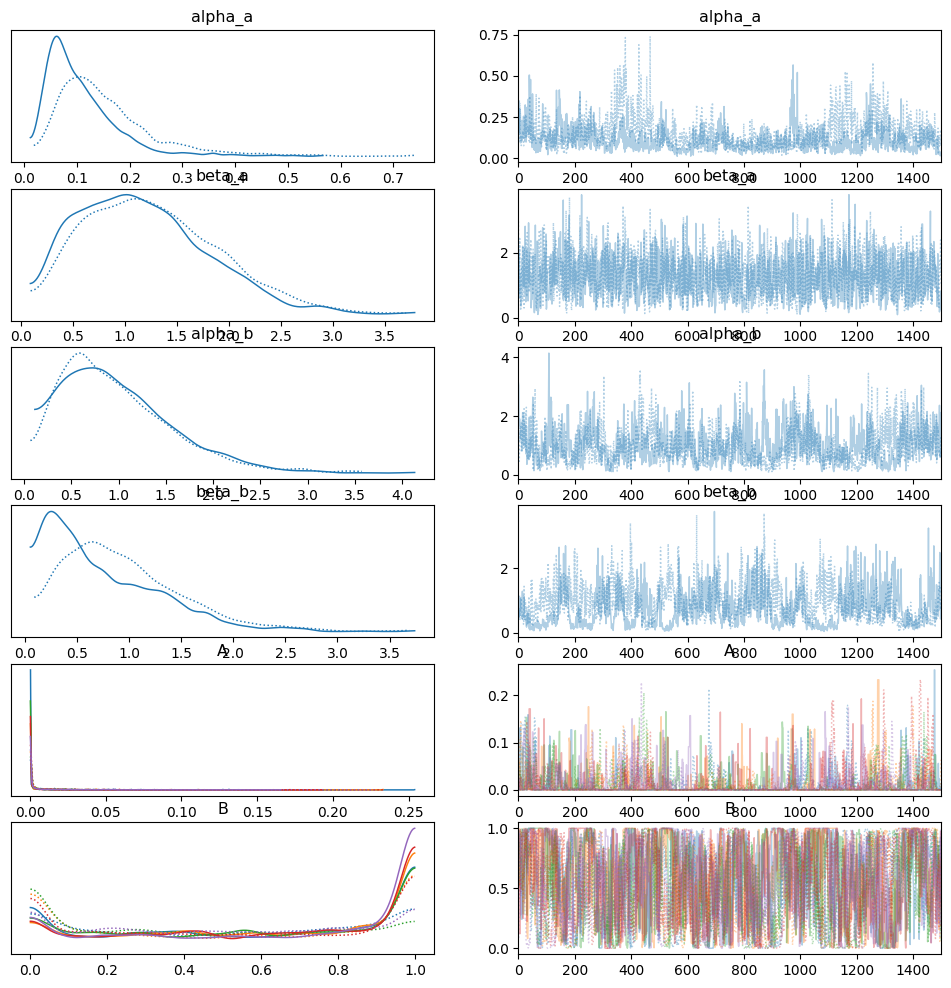

In [180]:
az.plot_trace(idata_mh);

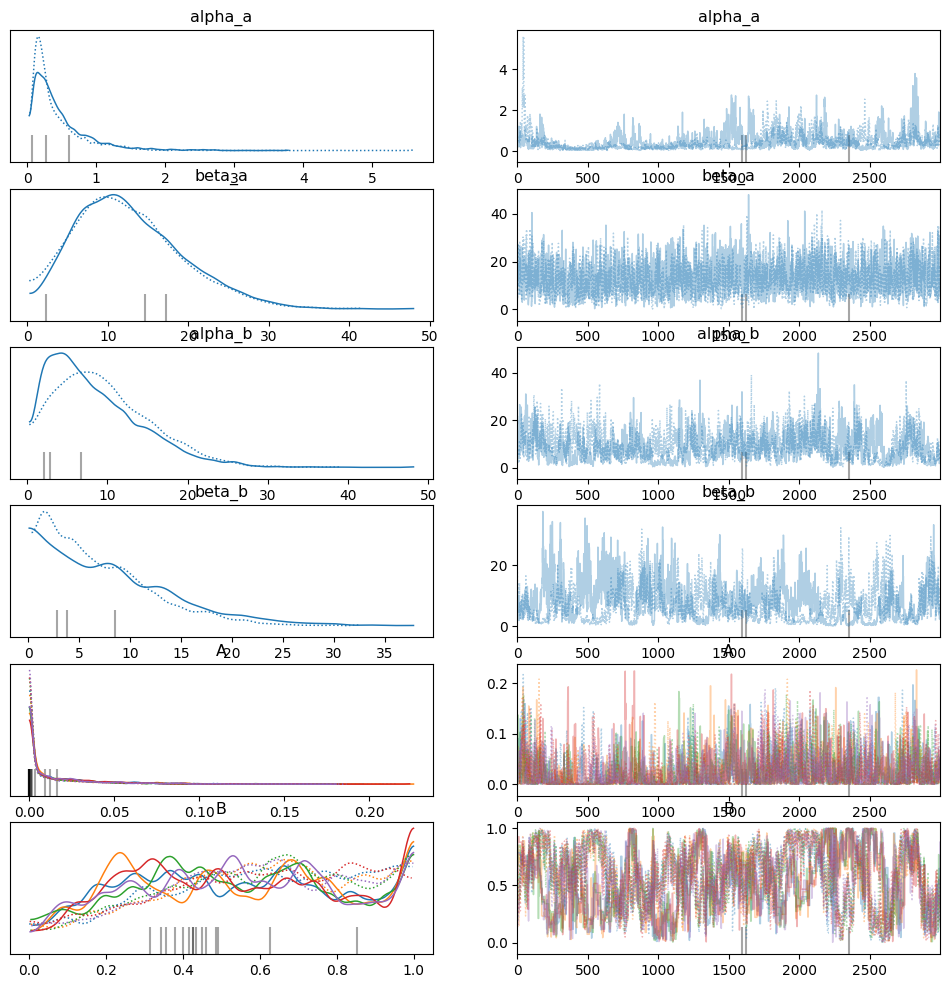

In [178]:
az.plot_trace(idata_mh);  # real and assumed disributions differed ; limited parameter values

array([[<Axes: ylabel='beta_a'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha_b'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_b'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='A\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='A\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='A\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes:

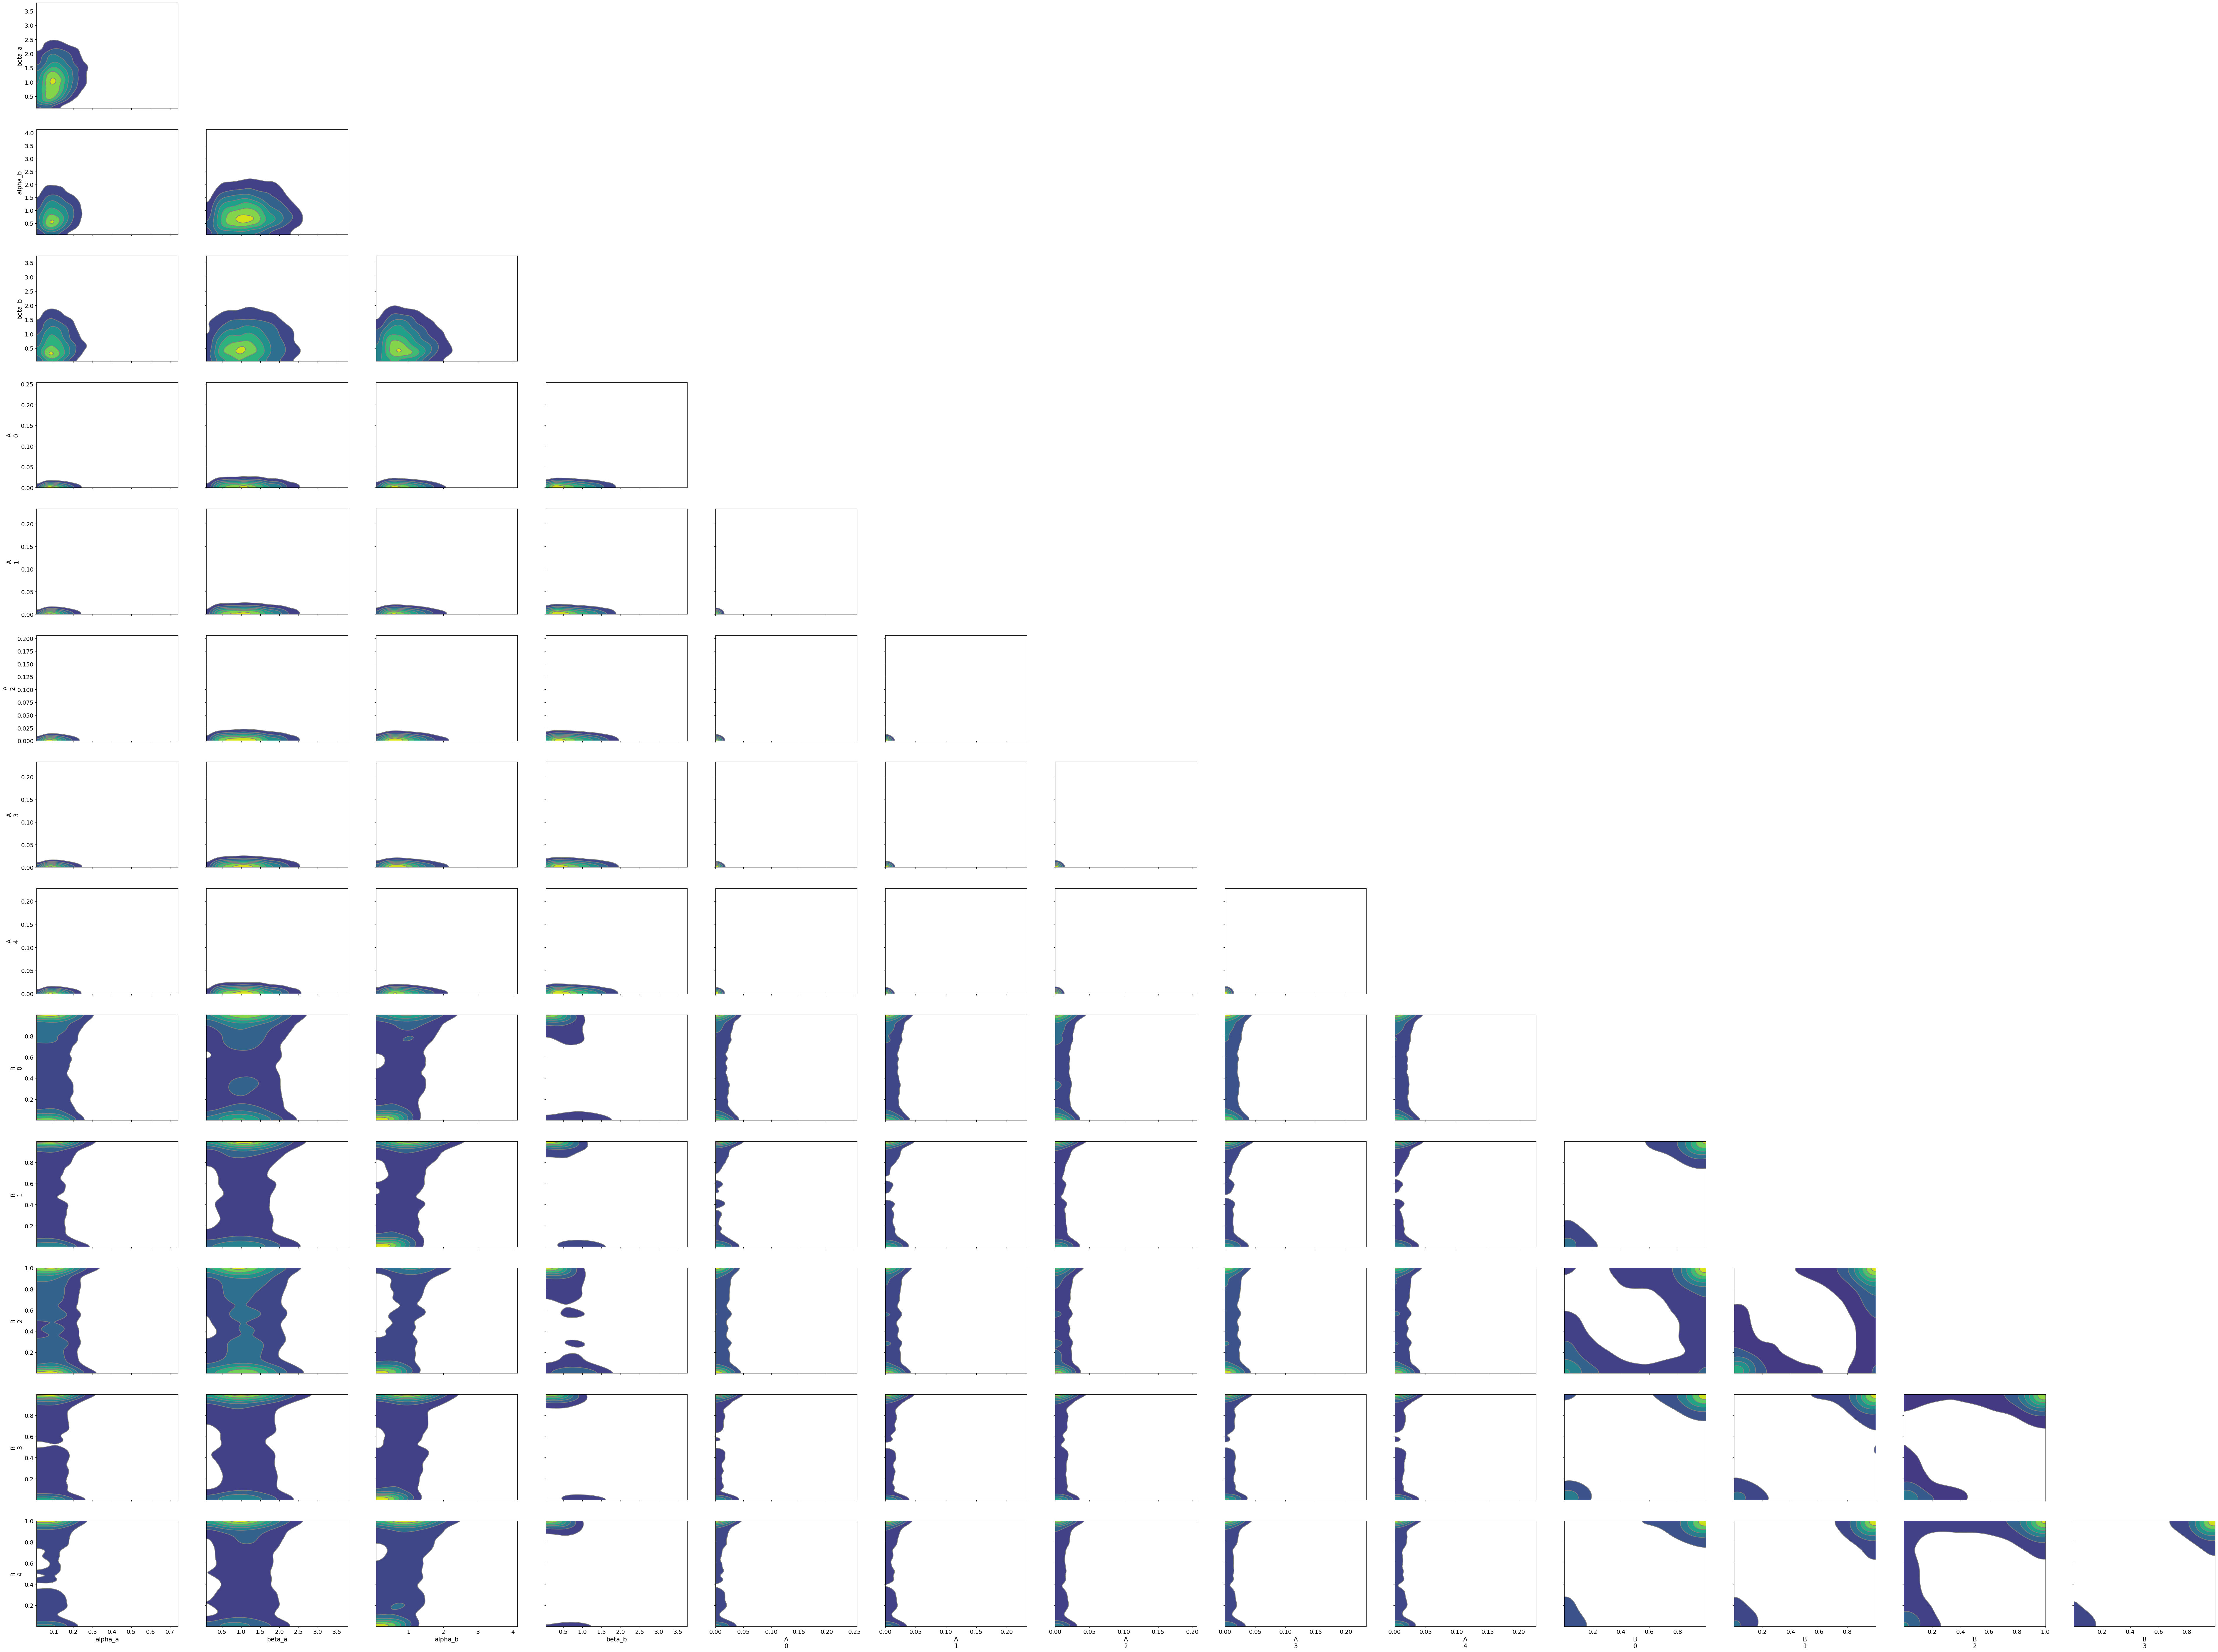

In [181]:
az.rcParams['plot.max_subplots'] = 100
az.plot_pair(idata_mh, kind="kde")

In [ ]:
az.plot_trace(idata_mh);  # bad beta values

###Trash

In [9]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, a, b, ll)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

array([-0.79813887, -0.59813887, -0.59813887, -0.90108961, -0.52108961,
       -0.52108961, -0.52108961, -0.52108961, -0.52108961, -0.52108961,
       -0.52108961, -1.00042683, -1.09505068, -0.40725068, -1.18426258,
       -1.26768372, -1.34517814, -1.41678671, -1.48267385, -0.25751482,
       -1.5430861 , -0.24044298, -0.24044298, -1.598321  , -1.64870418,
       -0.21356325, -0.21356325, -0.21356325, -0.21356325, -1.69457283,
       -0.20294599, -1.73626415, -0.1938    , -1.77410741, -0.18588967,
       -0.18588967, -1.80841872, -0.17902275, -0.17902275, -1.83949777,
       -1.867626  , -0.16781527, -1.89306575, -0.16323609, -0.16323609,
       -0.16323609, -0.16323609, -0.16323609, -1.91606016, -0.15921347,
       -1.93683352, -0.15567149, -0.15567149, -0.15567149, -0.15567149,
       -1.95559194, -0.15254612, -1.97252429, -1.98780313, -0.14733602,
       -0.14733602, -2.00158587, -0.14516547, -2.01401578, -0.14323741,
       -2.02522308, -2.03532601, -2.04443179, -2.05263755, -2.06

In [66]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, ll, a, b):

    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, ll, a, b)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

print(f"{C_test.shape}\n{R_test.shape}\n{Q_test.shape}\n()\n()\n()")

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

(100,)
(100,)
(2,)
()
()
()


array([-0.79813887, -0.59813887, -0.59813887, -0.90108961, -0.52108961,
       -0.52108961, -0.52108961, -0.52108961, -0.52108961, -0.52108961,
       -0.52108961, -1.00042683, -1.09505068, -0.40725068, -1.18426258,
       -1.26768372, -1.34517814, -1.41678671, -1.48267385, -0.25751482,
       -1.5430861 , -0.24044298, -0.24044298, -1.598321  , -1.64870418,
       -0.21356325, -0.21356325, -0.21356325, -0.21356325, -1.69457283,
       -0.20294599, -1.73626415, -0.1938    , -1.77410741, -0.18588967,
       -0.18588967, -1.80841872, -0.17902275, -0.17902275, -1.83949777,
       -1.867626  , -0.16781527, -1.89306575, -0.16323609, -0.16323609,
       -0.16323609, -0.16323609, -0.16323609, -1.91606016, -0.15921347,
       -1.93683352, -0.15567149, -0.15567149, -0.15567149, -0.15567149,
       -1.95559194, -0.15254612, -1.97252429, -1.98780313, -0.14733602,
       -0.14733602, -2.00158587, -0.14516547, -2.01401578, -0.14323741,
       -2.02522308, -2.03532601, -2.04443179, -2.05263755, -2.06

In [81]:
# parameters & variables
CM = pt.imatrix("CM") # choice vectors OVER PARTICIPANTS
RM = pt.dmatrix("RM") # reward vectors OVER PARTICIPANTS
QM = pt.dmatrix("QM") # empty matrix to store q-values across trials OVER PARTICIPANTS
A = pt.dvector("A") # vectors of learning rates OVER PARTICIPANTS
B = pt.dvector("B") # vectors of RL decision temperatures OVER PARTICIPANTS
llV = pt.dvector("llV")  # empty scalars to store ll value OVER PARTICIPANTS

def my_llV_func(CM, RM, QM, llV, A, B):
    # make mask function for multi-participant

    # c: scalar
    # ms: vector
    def mask_step(c,ms):
        # m = pt.set_subtensor(pt.zeros_like(q)[c], pt.constant(1))
        ms = pt.set_subtensor(ms[c], pt.constant(1))
        return ms

    # C: vector
    # Q: matrix
    ## M: matrix
    def make_mask(C,Q):
        # ms = pt.zeros((Q.shape[1]))
        ms = pt.zeros((Q.shape[0]))
        # ms = pt.dvector("ms")
        M, updates = pytensor.scan(mask_step, sequences=[C], outputs_info=ms)
        return M

    # function for a single RL step
    # C: vector
    # R: vector
    # Q_tm1: matrix
    # A: vector
    ## M: matrix
    def rl_step(C, R, A, Q_tm1):
        # m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        M = make_mask(C,Q_tm1)
        Rm = R * M
        Qm = Q_tm1 * M
        return Q_tm1 + A * (Rm - Qm)

    ### function to calculate loglikehood for each trial
    # C: vector
    # Qs: matrix
    # B: vector
    ## Ps: matrix
    ## M: matrix
    ## P_select: vector
    # llV: vector
    def ll_def(C, Qs, llV, B):
        # mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        M = make_mask(C,Qs)
        Ps = pt.exp(Qs/B) / pt.exp(Qs/B).sum(axis=1)
        P_select = (Ps * M).sum(axis=1)
        llV = pt.log(P_select)
        return llV

    ### scan function
    # CM: matrix [vector]
    # RM: matrix [vector]
    # A: vector
    ## M: matrix
    # QM: matrix --> tensor3
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [A], outputs_info=QM)

    # d0, d1, d2 = QsT3.shape
    # QsT3 = QsT3.reshape((d1,d0,d2))

    ### scan function
    # CM: matrix [vector]
    # QsT3: tensor3 [matrix]
    # B: vector
    ## M: matrix
    # llV: vector --> matrix
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[B], outputs_info=llV)

    # final output
    loglike = loglikes.sum()
    return loglike

output = my_llV_func(CM, RM, QM, llV, A, B)
# output = my_mll_func(CM, RM, QM, A, B)

loglike_func = pytensor.function(inputs=[CM,RM,QM,llV,A,B],outputs=output)
# loglike_func = pytensor.function(inputs=[CM,RM,QM,A,B],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
n_participants = 5
CM_test = np.array([np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32) for _ in range(n_participants)])
RM_test = np.array([np.ones((n_trials,), dtype=np.int32) for _ in range(n_participants)]) * C_test
QM_test = np.array([np.ones(shape=(n_choices,), dtype=pytensor.config.floatX) for _ in range(n_participants)])
llV_test = np.zeros((n_participants,))
A_test = np.random.randint(low=3,high=5,size=(n_participants,)) / 10
B_test = np.random.randint(low=6,high=9,size=(n_participants,)) / 10

# # (uncomment / comment) these lines to make it (work but produce nans / not work)
#CM_test = CM_test.transpose((1,0))  #.reshape((CM_test.shape[1],-1,CM_test.shape[0]))
#RM_test = RM_test.transpose((1,0))  #.reshape((RM_test.shape[1],-1,RM_test.shape[0]))
#QM_test = QM_test.transpose((1,0))  #.reshape((QM_test.shape[1],-1,QM_test.shape[0]))

print(f"{CM_test.shape}\n{RM_test.shape}\n{QM_test.shape}\n{A_test.shape}\n{B_test.shape}\n{llV_test.shape}")
# print(f"{CM_test.shape}\n{RM_test.shape}\n{QM_test.shape}\n{A_test.shape}")

# # RL Loglikelihood function test
loglike_func(CM_test,RM_test,QM_test,llV_test,A_test,B_test)
# loglike_func(CM_test,RM_test,QM_test,A_test,B_test)

(5, 100)
(5, 100)
(5, 2)
(5,)
(5,)
(5,)


ValueError: ignored

In [ ]:
# parameters & variables
CM = pt.imatrix("CM") # choice vectors OVER PARTICIPANTS
RM = pt.dmatrix("RM") # reward vectors OVER PARTICIPANTS
QM = pt.dmatrix("QM") # empty matrix to store q-values across trials OVER PARTICIPANTS
A = pt.dmatrix("A") # vectors of learning rates OVER PARTICIPANTS
B = pt.dmatrix("B") # vectors of RL decision temperatures OVER PARTICIPANTS
llV = pt.dvector("llV")  # empty scalars to store ll value OVER PARTICIPANTS

def my_llV_func(CM, RM, QM, llV, A, B):
    # make mask function for multi-participant

    # c: scalar
    # ms: vector (choices)
    def mask_step(c,ms):
        # m = pt.set_subtensor(pt.zeros_like(q)[c], pt.constant(1))
        ms = pt.set_subtensor(ms[c], pt.constant(1))
        return ms

    # C: vector (participants)
    # Q: matrix (participants,choices)
    ## M: matrix (choices,participants)
    def make_mask(C,Q):
        # ms = pt.zeros((Q.shape[1]))  # This line doesn't seem to work
        ms = pt.zeros((Q.shape[1]))
        # ms = pt.dvector("ms")
        M, updates = pytensor.scan(mask_step, sequences=[C], outputs_info=ms)
        return M

    # function for a single RL step
    # C: vector (participants)
    # R: vector (participants)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants)
    ## M: matrix ()
    def rl_step(C, R, A, Q_tm1):
        # m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        M = make_mask(C,Q_tm1)
        # M = M.reshape((M.shape[1],M.shape[0]))
        # R = pt.matmul(pt.ones((Q_tm1.shape[1],1)),R.reshape((1,R.shape[0])))
        R = pt.matmul(R.reshape((R.shape[0],1)),pt.ones((1,Q_tm1.shape[1])))  # Reshaping rewards to have same dimensionality as Q-values (participants,choices)
        Rm = pt.mul(R,M)
        # Rm = R * M
        Qm = pt.mul(Q_tm1,M)
        # Qm = Q_tm1 * M
        return Q_tm1 + pt.mul(A,(Rm - Qm))

    ### function to calculate loglikehood for each trial
    # C: vector (participants)
    # Qs: matrix (participants, choices)
    # B: vector (participants)
    ## Ps: matrix
    ## M: matrix
    ## P_select: vector
    # llV: vector
    def ll_def(C, Qs, llV, B):
        # mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        M = make_mask(C,Qs)
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.matmul(denom.reshape((denom.shape[0],1)),pt.ones((1,Qs.shape[1])))  # Reshaping denominator to have same dimensionality as numerator (participants,choices)
        Ps = pt.true_div(
            pt.exp(pt.true_div(Qs,B)),
            denom
            )
        P_select = pt.mul(Ps,M).sum(axis=1)
        llV = pt.log(P_select)
        return llV

    ### scan function
    # CM: matrix [vector] (trials,[participants])
    # RM: matrix [vector] (trials,[participants])
    # A: matrix (participants, choices)
    ## M: matrix ()
    # QM: matrix (participants, choices) --> tensor3
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [A], outputs_info=QM)

    # d0, d1, d2 = QsT3.shape
    # QsT3 = QsT3.reshape((d1,d0,d2))

    ### scan function
    # CM: matrix [vector] (trials,[participants])
    # QsT3: tensor3 [matrix]
    # B: vector
    ## M: matrix
    # llV: vector --> matrix
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[B], outputs_info=llV)

    # final output
    # loglike = loglikes.sum()
    return loglikes

output = my_llV_func(CM, RM, QM, llV, A, B)
# output = my_mll_func(CM, RM, QM, A, B)

loglike_func = pytensor.function(inputs=[CM,RM,QM,llV,A,B],outputs=output)
# loglike_func = pytensor.function(inputs=[CM,RM,QM,A,B],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
n_participants = 5
CM_test = np.array([np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32) for _ in range(n_participants)])
RM_test = np.array([np.ones((n_trials,), dtype=np.int32) for _ in range(n_participants)]) * C_test
QM_test = np.array([np.ones(shape=(n_choices,), dtype=pytensor.config.floatX) for _ in range(n_participants)])
llV_test = np.zeros((n_participants,))
A_test = np.random.randint(low=3,high=5,size=(n_participants,n_choices)) / 10
B_test = np.random.randint(low=6,high=9,size=(n_participants,n_choices)) / 10

# # (uncomment / comment) these lines to make it (work but produce nans / not work)
CM_test = CM_test.transpose((1,0))  #.reshape((CM_test.shape[1],-1,CM_test.shape[0]))
RM_test = RM_test.transpose((1,0))  #.reshape((RM_test.shape[1],-1,RM_test.shape[0]))
#QM_test = QM_test.transpose((1,0))  #.reshape((QM_test.shape[1],-1,QM_test.shape[0]))
#A_test = A_test.transpose((1,0))
#B_test = B_test.transpose((1,0))

print(f"CM: {CM_test.shape}\nRM: {RM_test.shape}\nQM: {QM_test.shape}\nA: {A_test.shape}\nB: {B_test.shape}\nllV: {llV_test.shape}")
# print(f"{CM_test.shape}\n{RM_test.shape}\n{QM_test.shape}\n{A_test.shape}")

# # RL Loglikelihood function test
loglike_func(CM_test,RM_test,QM_test,llV_test,A_test,B_test)
# loglike_func(CM_test,RM_test,QM_test,A_test,B_test)

In [ ]:
# define a pytensor Op for our likelihood function
class MultiLogLike(pt.Op):

    itypes = [pt.dmatrix]  # expects a matrix of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, r, c, ids, n_ids, n_trials):
        # add inputs as class attributes
        self.likelihood = loglike
        self.R = r
        self.C = c
        self.ids = ids
        self.n_ids = n_ids
        self.n_trials = n_trials

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      total = 0
      # total = np.zeros((len(self.ids.unique())))
      # for i, id in enumerate(self.unique_ids):
      #  id_index = self.ids[self.ids == id]
      for i in range(self.n_ids):
        r = self.R[i*self.n_trials:(i+1)*self.n_trials]
        c = self.C[i*self.n_trials:(i+1)*self.n_trials]
        a = theta[0][i]
        b = theta[1][i]
        total += self.likelihood(a,b, r, c)
      outputs[0][0] = np.array(total)